In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [ ]:
# Load all participant data
data_dir = Path('../human_data')
participant_dirs = [d for d in data_dir.iterdir() if d.is_dir()]

# Define pixelation levels in order (from highest to lowest pixelation)
pixelation_levels = [6.5, 5.0, 4.2, 3.5, 3.0, 2.6, 2.3, 2.0, 1.8, 1.6, 1.4, 1.2, 1.0]

# Create mapping from pixelation level to time step
level_to_step = {level: step + 1 for step, level in enumerate(pixelation_levels)}

# Load and process data for each participant
all_data = []
participant_names = []

for participant_dir in sorted(participant_dirs):
    csv_path = participant_dir / 'results.csv'
    if csv_path.exists():
        df = pd.read_csv(csv_path)
        
        # Filter to only rows where a guess was made
        guesses = df[df['action_taken'] == 'guess'].copy()
        
        # Calculate time step based on pixelation level
        guesses['time_step'] = guesses['pixelation_level'].map(level_to_step)
        
        # Add participant identifier (anonymized)
        participant_name = f"Participant {len(participant_names) + 1}"
        guesses['participant'] = participant_name
        
        all_data.append(guesses)
        participant_names.append(participant_name)

# Combine all data
combined_data = pd.concat(all_data, ignore_index=True)

print(f"Loaded data from {len(participant_names)} participants")
print(f"Total guesses: {len(combined_data)}")
print(f"\nParticipant breakdown:")
for name in participant_names:
    count = len(combined_data[combined_data['participant'] == name])
    print(f"  {name}: {count} guesses")

In [ ]:
# Plot 1: Overall distribution (histogram) of time steps at which participants guessed
plt.figure(figsize=(10, 6))
plt.hist(combined_data['time_step'], bins=range(1, len(pixelation_levels) + 2), 
         edgecolor='black', alpha=0.7, color='steelblue', density=True)
plt.xlabel('Time Step (when guess was made)', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.title('Overall Distribution of Time Steps at Which Participants Guessed', fontsize=14, fontweight='bold')
plt.xticks(range(1, len(pixelation_levels) + 1))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Plot 2: Overlaid distributions with each color corresponding to a participant
plt.figure(figsize=(12, 6))

# Get unique participants and assign colors
participants = combined_data['participant'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(participants)))

for i, participant in enumerate(sorted(participants)):
    participant_data = combined_data[combined_data['participant'] == participant]
    plt.hist(participant_data['time_step'], bins=range(1, len(pixelation_levels) + 2), 
             alpha=0.6, label=participant, color=colors[i], edgecolor='black', linewidth=0.5, density=True)

plt.xlabel('Time Step (when guess was made)', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.title('Distribution of Time Steps by Participant (Overlaid)', fontsize=14, fontweight='bold')
plt.xticks(range(1, len(pixelation_levels) + 1))
plt.legend(loc='best', fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Plot 3: Correctness as a function of time step they guessed
# Calculate correctness rate for each time step
correctness_by_step = combined_data.groupby('time_step')['correct'].agg(['mean', 'count']).reset_index()
correctness_by_step.columns = ['time_step', 'correctness_rate', 'count']

plt.figure(figsize=(10, 6))
plt.plot(correctness_by_step['time_step'], correctness_by_step['correctness_rate'], 
         marker='o', linewidth=2, markersize=8, color='darkgreen')
plt.xlabel('Time Step (when guess was made)', fontsize=12)
plt.ylabel('Correctness Rate', fontsize=12)
plt.title('Correctness Rate as a Function of Time Step', fontsize=14, fontweight='bold')
plt.xticks(range(1, len(pixelation_levels) + 1))
plt.ylim([0, 1.05])
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print some statistics
print("Correctness by time step:")
print(correctness_by_step)

In [ ]:
# Plot 4: Correctness by subject with their average guess time included
participant_stats = combined_data.groupby('participant').agg({
    'correct': 'mean',
    'time_step': 'mean'
}).reset_index()
participant_stats.columns = ['participant', 'correctness_rate', 'avg_time_step']

# Sort by participant name for consistent ordering
participant_stats = participant_stats.sort_values('participant')

fig, ax = plt.subplots(figsize=(12, 6))

# Create bar plot for correctness
x_pos = np.arange(len(participant_stats))
bars = ax.bar(x_pos, participant_stats['correctness_rate'], 
              alpha=0.7, color='steelblue', edgecolor='black')

# Add average time step as text annotation on each bar
for i, (idx, row) in enumerate(participant_stats.iterrows()):
    ax.text(i, row['correctness_rate'] + 0.02, 
            f"Avg step: {row['avg_time_step']:.1f}", 
            ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Participant', fontsize=12)
ax.set_ylabel('Correctness Rate', fontsize=12)
ax.set_title('Correctness Rate by Participant (with Average Guess Time Step)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(participant_stats['participant'], rotation=0)
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("\nParticipant Statistics:")
print(participant_stats.to_string(index=False))

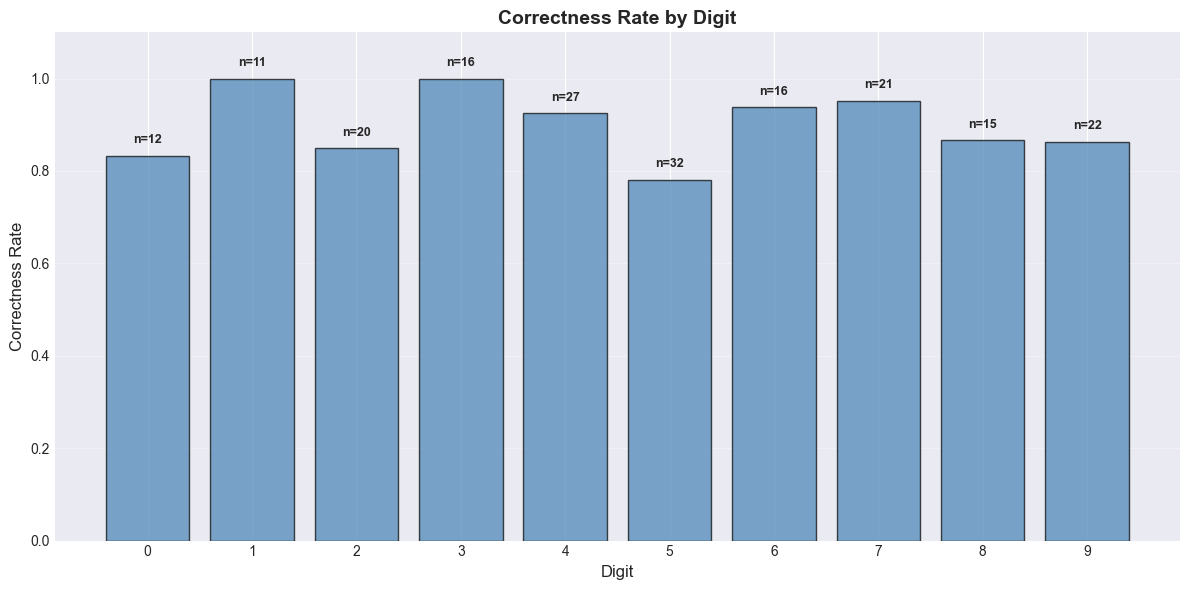


Correctness by digit:
 digit correctness_rate  count
     0         0.833333     12
     1              1.0     11
     2             0.85     20
     3              1.0     16
     4         0.925926     27
     5          0.78125     32
     6           0.9375     16
     7         0.952381     21
     8         0.866667     15
     9         0.863636     22


In [13]:
# Plot 5: Correctness by digit
correctness_by_digit = combined_data.groupby('class_label')['correct'].agg(['mean', 'count']).reset_index()
correctness_by_digit.columns = ['digit', 'correctness_rate', 'count']
correctness_by_digit = correctness_by_digit.sort_values('digit')

fig, ax = plt.subplots(figsize=(12, 6))

# Create bar plot for correctness by digit
x_pos = np.arange(len(correctness_by_digit))
bars = ax.bar(x_pos, correctness_by_digit['correctness_rate'], 
              alpha=0.7, color='steelblue', edgecolor='black')

# Add count as text annotation on each bar
for i, (idx, row) in enumerate(correctness_by_digit.iterrows()):
    ax.text(i, row['correctness_rate'] + 0.02, 
            f"n={row['count']}", 
            ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Digit', fontsize=12)
ax.set_ylabel('Correctness Rate', fontsize=12)
ax.set_title('Correctness Rate by Digit', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(correctness_by_digit['digit'], rotation=0)
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("\nCorrectness by digit:")
print(correctness_by_digit.to_string(index=False))